In [2]:
import findspark
findspark.init()
import pyspark as spark
from pyspark.sql.functions import udf, col
import pyspark.sql.functions as F
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from hsbmpy import get_max_available_L
from hsbmpy import get_file
import tensorflow as tf

In [ ]:
import importlib, geneontology
from geneontology import *
importlib.reload(geneontology)
from geneontology import *

In [3]:
sc = spark.SparkContext()
sql = spark.SQLContext(sc)

In [156]:
label='primary_site'
labels = ['primary_site', 'disease_type', 'disease_tissue']
#labels = ['primary_site', 'secondary_site']
algorithm = 'topsbm'
#labels = ['primary_site', 'secondary_site', 'status']
#labels=['RPPA Clusters']
directory = "/home/fvalle/phd/datasets/altmann/"
L=get_max_available_L(directory, algorithm)
os.chdir(directory)

In [157]:
df_Pwt = sql.read.option('header',True).csv("%s/%s/%s_level_%d_word-dist.csv"%(directory,algorithm,algorithm,L))

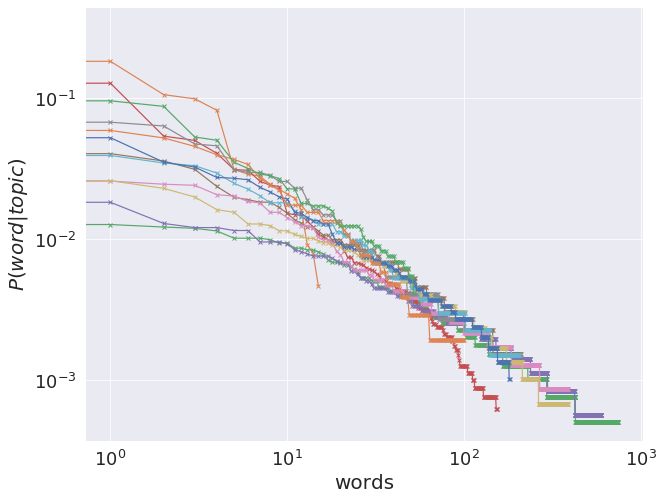

In [158]:
fig=plt.figure(figsize=(10,8))
plt.title("")
for topic in df_Pwt.columns[:]:
    dist = df_Pwt.select([topic]).filter(F.col(topic)>1e-50).sort([topic], ascending=False).toPandas().astype(float).values
    if len(dist)<2:
        pass
    plt.plot(np.sort(dist[dist>0].T)[::-1], marker='x', label=topic)
plt.ylabel("$P(word | topic$)", fontsize=20)
plt.xlabel("words", fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=18)
#plt.legend()
plt.show()
fig.savefig("p_w_tw_%s.pdf"%algorithm)

In [159]:
df_Ptd = sql.read.option('header',True).csv("%s/%s/%s_level_%d_topic-dist.csv"%(directory,algorithm,algorithm,L)).drop('i_doc')

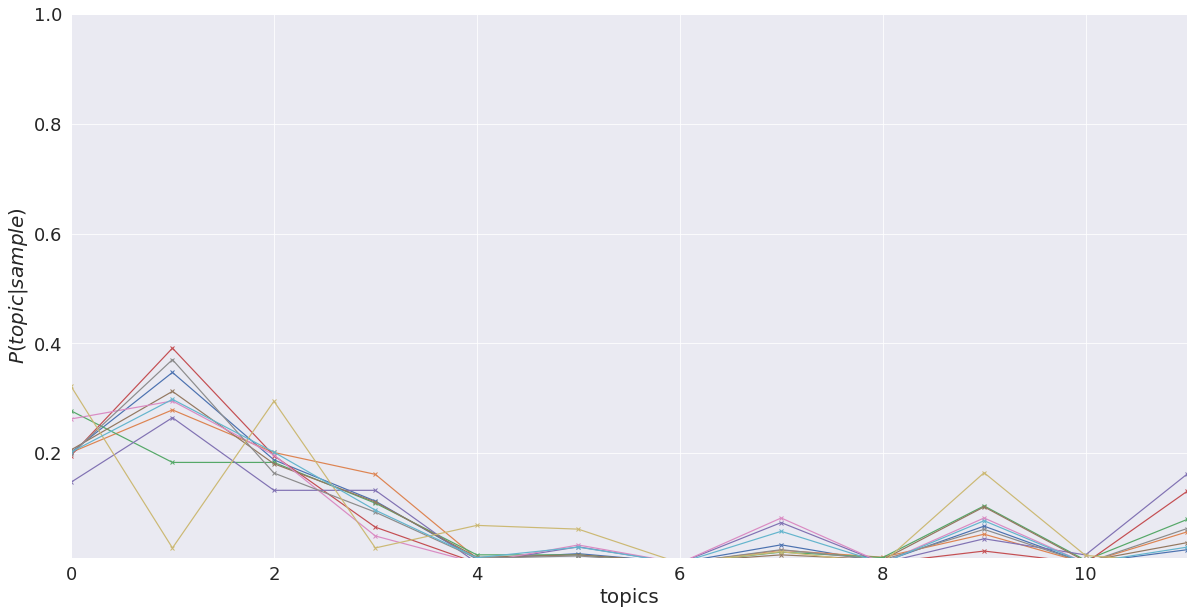

In [160]:
fig=plt.figure(figsize=(20,10))
plt.ylabel("$P(topic | sample$)", fontsize=20)
plt.xlabel("topics", fontsize=20)
for sample in df_Ptd.select('doc').toPandas().values[:10]:
    plt.plot(df_Ptd.filter(F.col('doc')==sample[0]).drop('doc').toPandas().astype(float).values[0], marker='x')
    #plt.plot(np.sort(df_Ptd.filter(F.col('doc')==sample[0]).drop('doc').toPandas().astype(float).values[0])[::-1], lw=0.1, marker='x')
#plt.plot(np.logspace(0,2),1/np.logspace(0,2))
#plt.xscale('log')
#plt.yscale('log')
plt.ylim(1e-2,1)
plt.xlim(0,len(df_Ptd.columns)-2)
plt.tick_params(labelsize=18)
plt.show()
fig.savefig("p_t_s_%s.pdf"%algorithm)

In [163]:
df_mt = pd.read_csv("mainTable_all.csv",index_col=0)
df_files=pd.read_csv("files.dat", index_col=0)
df_mt=df_mt.reindex(index=df_Pwt.select('_c0').toPandas().values.ravel(),
                    columns=[get_file(sample, df_files).name for sample in df_Ptd.select('doc').toPandas().values.ravel()])
df_mt.dropna(inplace=True)
#df_mt=df_mt.where(df_mt<1e4,1e4)

In [164]:
Pgt = tf.convert_to_tensor(df_Pwt.toPandas().set_index('_c0').astype(float).values)
Pts = tf.transpose(tf.convert_to_tensor(df_Ptd.toPandas().set_index('doc').astype(float).values))
Pgs = tf.matmul(Pgt,Pts)
Ps = tf.convert_to_tensor(df_mt.sum(0).values)
Ps = tf.divide(Ps, tf.reduce_sum(Ps))#normalize
Pg = tf.squeeze(tf.matmul(Pgs, tf.reshape(Ps,[Ps.shape[0].value,1])))

In [165]:
print(Pgt.shape,Pts.shape,Pgs.shape,Pg.shape, Ps.shape)

(3140, 12) (12, 63) (3140, 63) (3140,) (63,)


In [166]:
with tf.Session() as sess:
    Pgs_data, Pg_data = sess.run([Pgs,Pg])
Pgs_data.shape

(3140, 63)

In [167]:
df_Pgs = pd.DataFrame(data=Pgs_data, index=df_Pwt.toPandas().values.T[0], columns=df_Ptd.select(['doc']).toPandas().values.T[0])

In [168]:
A=df_mt.sum(1).values

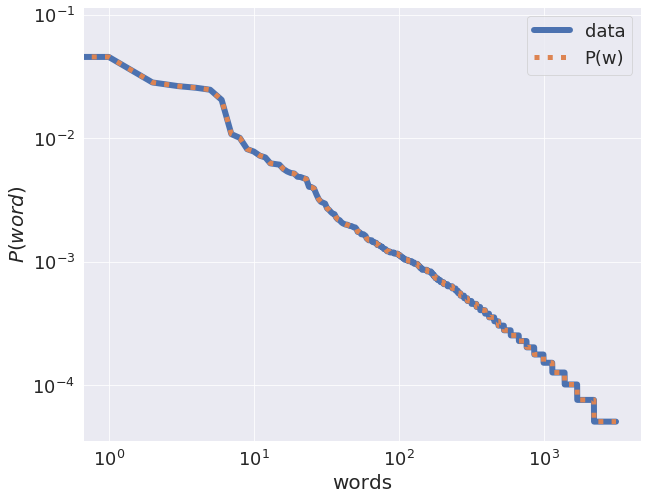

In [169]:
fig=plt.figure(figsize=(10,8))
plt.plot(np.sort(A)[::-1]/A.sum(), lw=6, ls='-', label='data')
plt.plot(np.sort(Pg_data)[::-1]/np.sum(Pg_data), lw=5, ls=':', label='P(w)')
plt.ylabel("$P(word$)", fontsize=20)
plt.xlabel("words", fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=18)
plt.legend(fontsize=18)
plt.show()
fig.savefig("p_w_%s.pdf"%algorithm)

In [147]:
A_lda=Pg_data

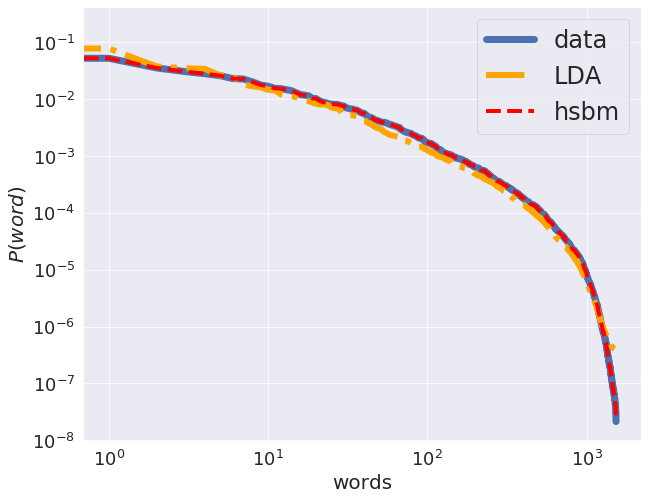

In [110]:
fig=plt.figure(figsize=(10,8))
plt.plot(np.sort(A)[::-1]/A.sum(), lw=7, ls='-', label='data')
plt.plot(np.sort(A_lda)[::-1]/np.sum(A_lda), lw=6, ls='-.', c='orange', label='LDA')
plt.plot(np.sort(Pg_data)[::-1]/np.sum(Pg_data), lw=4, ls='--', c='red', label='hsbm')
plt.ylabel("$P(word$)", fontsize=20)
plt.xlabel("words", fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labelsize=18)
plt.legend(fontsize=24)
plt.show()
fig.savefig("p_w.pdf")